# GOES-18 Satellite Imagery: Utah Region

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/national-data-platform/ep-tutorials/blob/main/examples/goes-utah-satellite.ipynb)

This example demonstrates an end-to-end workflow using NDP-EP:

1. **Register** external GOES-18 data (from AWS) in the NDP-EP catalog
2. **Download** satellite imagery from the registered source
3. **Process** and crop to Utah region
4. **Upload** processed data to local S3 storage
5. **Register** the processed dataset in NDP-EP
6. **Visualize** with interactive maps

## Prerequisites

- Access to an NDP-EP API instance
- Valid authentication token

## Setup

Install required packages:

In [ ]:
!pip install ndp-ep xarray netCDF4 pyproj folium numpy requests pillow -q

In [1]:
import numpy as np
import xarray as xr
import requests
import folium
from pyproj import CRS, Transformer
from ndp_ep import Client
import tempfile
import os

## Configuration

Set your NDP-EP API endpoint and token:

In [2]:
# NDP-EP Configuration
API_URL = "http://localhost:8002"  # Change to your API endpoint
TOKEN = "testing_token"            # Change to your token
ORGANIZATION = "noaa-demo"         # Organization for registering datasets

# Initialize client
client = Client(base_url=API_URL, token=TOKEN)

# Verify connection and check all services
status = client.get_system_status()

print(f"NDP-EP: {status['ep_name']}")
print(f"API Version: {status['api_version']}")
print(f"")
print("Services status:")
print(f"  - Local Catalog: {'✓ Connected' if status.get('backend_connected') else '✗ NOT CONNECTED'}")
print(f"  - S3 Storage:    {'✓ Connected' if status.get('s3_connected') else '✗ NOT CONNECTED'}")
print(f"  - Kafka:         {'✓ Enabled' if status.get('kafka_enabled') else '- Disabled'}")

# Check if we can proceed
if not status.get('backend_connected'):
    raise RuntimeError("❌ Local catalog is not connected. Please check your NDP-EP configuration.")

if not status.get('s3_connected'):
    raise RuntimeError("❌ S3 storage is not connected. Please check your MinIO/S3 configuration.")

# Ensure organization exists
existing_orgs = client.list_organizations(server="local")
if ORGANIZATION not in existing_orgs:
    print(f"\nOrganization '{ORGANIZATION}' not found. Creating it...")
    client.register_organization({
        "name": ORGANIZATION,
        "title": "NOAA Demo Organization",
        "description": "Demo organization for NOAA satellite data examples"
    })
    print(f"  ✓ Organization '{ORGANIZATION}' created")
else:
    print(f"\n✓ Organization '{ORGANIZATION}' exists")

print("\n✓ All required services are available. Ready to proceed!")

NDP-EP: EP-DEMO
API Version: 0.4.0

Services status:
  - Local Catalog: ✓ Connected
  - S3 Storage:    ✓ Connected
  - Kafka:         ✓ Enabled

✓ Organization 'noaa-demo' exists

✓ All required services are available. Ready to proceed!


## Step 1: Register GOES-18 External Data Source

NOAA provides GOES-18 satellite data publicly on AWS S3. We'll register this external data source in our NDP-EP catalog.

In [3]:
# GOES-18 data on AWS (publicly accessible)
GOES_AWS_BUCKET = "noaa-goes18"
GOES_PRODUCT = "ABI-L2-MCMIPC"  # Multi-band Cloud/Moisture Imagery - CONUS

# Sample file from November 25, 2024 at 18:00 UTC
GOES_FILE_KEY = "ABI-L2-MCMIPC/2024/330/18/OR_ABI-L2-MCMIPC-M6_G18_s20243301801170_e20243301803543_c20243301804085.nc"
GOES_FILE_URL = f"https://{GOES_AWS_BUCKET}.s3.amazonaws.com/{GOES_FILE_KEY}"

print(f"GOES-18 file URL: {GOES_FILE_URL}")

GOES-18 file URL: https://noaa-goes18.s3.amazonaws.com/ABI-L2-MCMIPC/2024/330/18/OR_ABI-L2-MCMIPC-M6_G18_s20243301801170_e20243301803543_c20243301804085.nc


In [4]:
# Register the external GOES data source in NDP-EP catalog
# Note: This registers metadata pointing to the AWS location

try:
    result = client.register_url({
        "resource_name": "goes18-conus-sample",
        "resource_title": "GOES-18 CONUS Multi-band Imagery Sample",
        "owner_org": ORGANIZATION,
        "resource_url": GOES_FILE_URL,
        "file_type": "NetCDF",
        "notes": "GOES-18 ABI L2 Cloud and Moisture Imagery Product (MCMIPC) for CONUS region. Source: NOAA AWS Open Data."
    })
    print(f"Registered external dataset: {result}")
except Exception as e:
    print(f"Dataset may already exist or error: {e}")

Registered external dataset: {'id': '81f04f87-a862-4531-a0fc-287f63b95021'}


## Step 2: Search and Download the Data

Now we can discover this data through the NDP-EP catalog and download it.

In [ ]:
# Search for GOES data in the catalog
datasets = client.search_datasets(terms=["goes18"])
print(f"Found {len(datasets)} GOES datasets")

for dataset in datasets[:5]:
    print(f"  - {dataset['name']}: {dataset.get('title', 'N/A')}")

In [6]:
# Download the GOES file
print("Downloading GOES-18 file (~55MB)...")

temp_dir = tempfile.mkdtemp()
goes_file = os.path.join(temp_dir, "goes18_conus.nc")

response = requests.get(GOES_FILE_URL, stream=True)
total_size = int(response.headers.get('content-length', 0))

with open(goes_file, 'wb') as f:
    downloaded = 0
    for chunk in response.iter_content(chunk_size=8192):
        f.write(chunk)
        downloaded += len(chunk)
        if total_size:
            print(f"\rDownloading: {downloaded/1e6:.1f}/{total_size/1e6:.1f} MB", end="")

print(f"\nDownloaded to: {goes_file}")

Downloading: 57.3/57.3 MB
Downloaded to: /tmp/tmpymrayly6/goes18_conus.nc


## Step 3: Process and Crop to Utah Region

We'll extract the visible band (CMI_C02 - Red) and crop to Utah's boundaries.

In [7]:
# Utah geographic bounds
UTAH_BOUNDS = {
    'lat_min': 37.0,
    'lat_max': 42.0,
    'lon_min': -114.0,
    'lon_max': -109.0
}

print(f"Utah bounds: {UTAH_BOUNDS}")

Utah bounds: {'lat_min': 37.0, 'lat_max': 42.0, 'lon_min': -114.0, 'lon_max': -109.0}


In [8]:
# Open the GOES file
ds = xr.open_dataset(goes_file)

# Get projection parameters
proj = ds['goes_imager_projection']
h = proj.attrs['perspective_point_height']
lon_0 = proj.attrs['longitude_of_projection_origin']
sweep = proj.attrs.get('sweep_angle_axis', 'x')

print(f"Satellite: GOES-18 at {lon_0}°W")
print(f"Perspective height: {h/1e6:.1f} km")

Satellite: GOES-18 at -137.0°W
Perspective height: 35.8 km


In [9]:
# Create coordinate transformation
goes_crs = CRS.from_cf({
    'grid_mapping_name': 'geostationary',
    'longitude_of_projection_origin': lon_0,
    'perspective_point_height': h,
    'sweep_angle_axis': sweep,
    'semi_major_axis': proj.attrs['semi_major_axis'],
    'semi_minor_axis': proj.attrs['semi_minor_axis'],
})

transformer = Transformer.from_crs(goes_crs, "EPSG:4326", always_xy=True)

# Get coordinates
x = ds['x'].values * h
y = ds['y'].values * h
xx, yy = np.meshgrid(x, y)

# Transform to lat/lon
lon, lat = transformer.transform(xx, yy)

print(f"Image coverage:")
print(f"  Latitude: {np.nanmin(lat):.1f}° to {np.nanmax(lat):.1f}°")
print(f"  Longitude: {np.nanmin(lon):.1f}° to {np.nanmax(lon):.1f}°")

Image coverage:
  Latitude: 14.6° to 53.5°
  Longitude: -180.0° to 180.0°


In [10]:
# Find Utah region indices
utah_mask = (
    (lat >= UTAH_BOUNDS['lat_min']) & 
    (lat <= UTAH_BOUNDS['lat_max']) & 
    (lon >= UTAH_BOUNDS['lon_min']) & 
    (lon <= UTAH_BOUNDS['lon_max'])
)

utah_indices = np.where(utah_mask)
y_min, y_max = utah_indices[0].min(), utah_indices[0].max()
x_min, x_max = utah_indices[1].min(), utah_indices[1].max()

print(f"Utah region: {y_max-y_min} x {x_max-x_min} pixels")

Utah region: 193 x 257 pixels


In [11]:
# Extract Utah subset - using visible band (C02 - Red, 0.64 µm)
cmi_full = ds['CMI_C02'].values
cmi_utah = cmi_full[y_min:y_max, x_min:x_max]
lat_utah = lat[y_min:y_max, x_min:x_max]
lon_utah = lon[y_min:y_max, x_min:x_max]

print(f"Utah subset shape: {cmi_utah.shape}")
print(f"Reflectance range: {np.nanmin(cmi_utah):.3f} to {np.nanmax(cmi_utah):.3f}")

Utah subset shape: (193, 257)
Reflectance range: 0.030 to 0.433


In [12]:
# Save Utah subset as NetCDF
utah_file = os.path.join(temp_dir, "goes18_utah.nc")

utah_ds = xr.Dataset({
    'reflectance': (['y', 'x'], cmi_utah),
    'latitude': (['y', 'x'], lat_utah),
    'longitude': (['y', 'x'], lon_utah),
})

utah_ds.attrs = {
    'title': 'GOES-18 Utah Region Subset',
    'source': 'NOAA GOES-18 ABI L2 MCMIPC',
    'band': 'C02 (Red, 0.64 µm)',
    'processing': 'Cropped to Utah bounds',
    'bounds': str(UTAH_BOUNDS),
}

utah_ds.to_netcdf(utah_file)
print(f"Saved Utah subset: {utah_file}")
print(f"File size: {os.path.getsize(utah_file)/1e6:.2f} MB")

Saved Utah subset: /tmp/tmpymrayly6/goes18_utah.nc
File size: 1.00 MB


## Step 4: Upload to Local S3 Storage

Upload the processed Utah subset to the NDP-EP S3 storage.

In [13]:
# Create a bucket for satellite data
BUCKET_NAME = "satellite-data"

try:
    result = client.create_bucket(BUCKET_NAME)
    print(f"Created bucket: {result}")
except Exception as e:
    print(f"Bucket may already exist: {e}")

Created bucket: {'message': "Bucket 'satellite-data' created successfully", 'success': True}


In [14]:
# Upload the Utah NetCDF file
with open(utah_file, 'rb') as f:
    utah_data = f.read()

result = client.upload_object(
    bucket_name=BUCKET_NAME,
    object_key="goes18/utah/goes18_utah_20241125_1800.nc",
    file_data=utah_data,
    content_type="application/x-netcdf"
)

print(f"Uploaded: {result}")

Uploaded: {'bucket': 'satellite-data', 'key': 'goes18/utah/goes18_utah_20241125_1800.nc', 'size': 999880, 'etag': '59b42044b038fb5ae0d5d24333162999'}


In [15]:
# Generate a shareable URL
url_result = client.generate_presigned_download_url(
    bucket_name=BUCKET_NAME,
    object_key="goes18/utah/goes18_utah_20241125_1800.nc",
    expiration=86400  # 24 hours
)

print(f"Shareable URL (valid 24h): {url_result['url'][:80]}...")

Shareable URL (valid 24h): http://minio:9000/satellite-data/goes18/utah/goes18_utah_20241125_1800.nc?X-Amz-...


## Step 5: Register Processed Dataset

Register the processed Utah dataset in the NDP-EP catalog.

In [16]:
# Register the Utah subset as a new S3 resource
try:
    result = client.register_s3_link({
        "resource_name": "goes18-utah-subset",
        "resource_title": "GOES-18 Utah Region Satellite Imagery",
        "owner_org": ORGANIZATION,
        "s3_bucket": BUCKET_NAME,
        "s3_key": "goes18/utah/goes18_utah_20241125_1800.nc",
        "resource_s3": f"{BUCKET_NAME}/goes18/utah/goes18_utah_20241125_1800.nc",
        "notes": "Processed GOES-18 visible band imagery cropped to Utah region (37-42°N, 109-114°W)."
    })
    print(f"Registered processed dataset: {result}")
except Exception as e:
    print(f"Registration result: {e}")

Registered processed dataset: {'id': '4851fd6b-3c99-4850-aeb9-734db836590d'}


## Step 6: Search and Verify

Search for Utah data in the catalog.

In [ ]:
# Search for Utah datasets
utah_datasets = client.search_datasets(terms=["utah"])
print(f"Found {len(utah_datasets)} Utah datasets:")

for dataset in utah_datasets:
    print(f"  - {dataset['name']}: {dataset.get('title', 'N/A')}")

## Step 7: Interactive Visualization with Folium

Create an interactive map showing the satellite imagery over Utah.

In [18]:
# Normalize reflectance to 0-255 for visualization
cmi_normalized = np.clip(cmi_utah, 0, 1)
cmi_normalized = np.nan_to_num(cmi_normalized, nan=0)

# Apply gamma correction for better visibility
gamma = 0.5
cmi_gamma = np.power(cmi_normalized, gamma)

# Convert to RGB (grayscale)
cmi_uint8 = (cmi_gamma * 255).astype(np.uint8)

In [19]:
# Save as PNG for Folium overlay
from PIL import Image

# Create grayscale image
img = Image.fromarray(cmi_uint8, mode='L')
png_file = os.path.join(temp_dir, "utah_satellite.png")
img.save(png_file)

print(f"Saved visualization: {png_file}")

Saved visualization: /tmp/tmpymrayly6/utah_satellite.png


In [20]:
# Get actual bounds from the data
bounds = [
    [np.nanmin(lat_utah), np.nanmin(lon_utah)],  # Southwest
    [np.nanmax(lat_utah), np.nanmax(lon_utah)]   # Northeast
]

print(f"Image bounds: {bounds}")

Image bounds: [[np.float64(36.72408246655925), np.float64(-116.0118302867396)], [np.float64(42.44318119152858), np.float64(-106.06662767546887)]]



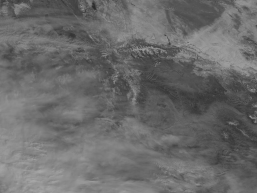

In [22]:
# Create interactive map
import base64

# Center on Utah
utah_center = [39.5, -111.5]

# Create map
m = folium.Map(
    location=utah_center,
    zoom_start=7,
    tiles='OpenStreetMap'
)

# Read image as base64
with open(png_file, 'rb') as f:
    img_data = base64.b64encode(f.read()).decode()

# Add satellite image overlay
img_overlay = folium.raster_layers.ImageOverlay(
    image=f"data:image/png;base64,{img_data}",
    bounds=bounds,
    opacity=0.7,
    name="GOES-18 Visible Band"
)
img_overlay.add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Add title
title_html = '''
<div style="position: fixed; 
            top: 10px; left: 50px; width: 300px;
            background-color: white; padding: 10px;
            border-radius: 5px; box-shadow: 2px 2px 5px gray;">
    <b>GOES-18 Satellite Imagery</b><br>
    Utah Region - Visible Band (0.64 µm)<br>
    <small>November 25, 2024 18:00 UTC</small>
</div>
'''
m.get_root().html.add_child(folium.Element(title_html))

# Display map
m

## Cleanup

Optionally clean up the temporary files and registered datasets.

In [23]:
# Close the dataset
ds.close()

# Uncomment to clean up:
# client.delete_object(BUCKET_NAME, "goes18/utah/goes18_utah_20241125_1800.nc")
# client.delete_bucket(BUCKET_NAME)

print("Done!")

AttributeError: 'dict' object has no attribute 'close'

## Summary

In this example, we demonstrated:

1. **Data Discovery**: Registering external data sources (NOAA AWS) in NDP-EP
2. **Data Processing**: Downloading and cropping satellite imagery to a region of interest
3. **Data Management**: Uploading processed data to local S3 storage
4. **Cataloging**: Registering derived datasets for discovery
5. **Visualization**: Creating interactive maps with Folium

This workflow can be adapted for other satellite products, regions, or time series analysis.